# Setup

## Imports

In [71]:
# Import Libraries
library(tidyverse)
library(data.table)
library(broom)
library(dtplyr)
library(lme4)
library(lmerTest)
library(ggbeeswarm)
library(cowplot)
library(tibble)

# Load helper functions
source("r_scripts/helper_functions.R")
source("https://raw.githubusercontent.com/hauselin/Rcode/master/cleanQuestionnaire.R")

## set universal plot size:
options(repr.plot.width=7, repr.plot.height=3.5)

# avoids scientific notation
options(scipen=999) 

## Load and manipulate data

In [72]:
# Read in data
df = as_tibble(read_csv("data/questionnaires.csv"), stringsAsFactors = FALSE)
# Select fMRI study subjects
fmri_sub <- grepl("FRMRI*", df[, 2][[1]])
df = df[fmri_sub, ]

# Rename Columns
names(df)[1:13] = c("demo_time",
                    "subject",
                    "demo_gender",
                    "demo_race",
                    "demo_age",
                    "demo_weight",
                    "demo_height",
                    "demo_yrs_canada",
                    "demo_diet",
                    "demo_diet_detail",
                    "demo_familiar",
                    "demo_previous_food",
                    "demo_previous_food_time")

# Just want id number
df <- df %>%
  mutate(
    subject = readr::parse_number(subject)
  )
  
# rename condition effects
cols = c(14,16,17,15,18,19,20,114,115,116,117)
colnames(df)[cols] <- c(paste0("ce_", 1:11))

# rename strategy questions
cols = c(21:28, 118:125)
colnames(df)[cols] <- c(paste0("s_", 1:16))

# rename Three Factor Eating Questionnaire
cols = c(29:46)
colnames(df)[cols] <- c(paste0("tfeq_", 1:18))

# rename rapid food screener
    # fruits and veg
cols = c(47:56)
colnames(df)[cols] <- c(paste0("rfs_fv_", 1:10))

    # fat
cols = c(57:73)
colnames(df)[cols] <- c(paste0("rfs_f_", 1:17))

# BIS 11
cols = c(74:103)
colnames(df)[cols] <- c(paste0("bis_", 1:30))

# Perceived Stress Scale
cols = c(104:113)
colnames(df)[cols] <- c(paste0("pss_", 1:10))

# reorder
df =df[,order(colnames(df))]

Parsed with column specification:
cols(
  .default = col_character(),
  `What time did you eat the food you indicated in the last question?` = col_time(format = ""),
  `How difficult was it to make choices during trials when you were asked to RESPOND NATURALLY?` = col_double(),
  `How difficult was it to make choices during trials when you were asked to DECREASE YOUR DESIRE?` = col_double(),
  `How much did you think about the health of the foods when choosing NATURALLY?` = col_double(),
  `How much did you try to decrease your desire for the foods when choosing NATURALLY?` = col_double(),
  `How much did you think about the health of the foods when trying to DECREASE DESIRE?` = col_double(),
  `How much did you try to reduce your craving for the foods when trying to DECREASE DESIRE?` = col_double(),
  `How successful do you think you were in controlling your responses to the food when you were asked to DECREASE DESIRE?` = col_double(),
  `1. I tried to think about how UNHEALTHY the fo

In [73]:
# want to look only at the subjects that were kept
good_subjects = c(101:104, 106:112, 114, 116, 118:121, 123:126, 129:137, 139:140, 142:148, 150, 152:158, 162:164)
# remove "bad" subjects
df_good = df %>%
    filter(subject %in% good_subjects)

In [74]:
# Make a copy of the dataframe
df_good_copy <- data.frame(df_good)

In [75]:
# Create vectors containing columns for each scale
bis_cols = NULL
pss_cols = NULL
rfs_cols = NULL
tfeq_cols = NULL

# Match item name to string subset for each scale
for (name in names(df_good_copy)){
    if (grepl("bis_", name, fixed = TRUE)){
        bis_cols <- append(bis_cols, name)
    } else if (grepl("pss_", name, fixed = TRUE)){
        pss_cols <- append(pss_cols, name)
    } else if (grepl("rfs_", name, fixed = TRUE)){
        rfs_cols <- append(rfs_cols, name)
    } else if (grepl("tfeq_", name, fixed = TRUE)){
        tfeq_cols <- append(tfeq_cols, name)
    }
}

In [76]:
# Recode values in bis columns
df_good_copy <- df_good_copy %>%
mutate_at(bis_cols, funs(recode(., "Rarely" = 1,
                                "Occasionally" = 2,
                                "Often" = 3,
                                "Almost always/Always" = 4,
                                .default = NaN)))

# Recode values in pss columns
df_good_copy <- df_good_copy %>%
mutate_at(pss_cols, funs(recode(., "Never" = 0,
                                "Almost Never" = 1,
                                "Sometimes" = 2,
                                "Fairly Often" = 3,
                                "Very Often" = 4,
                                .default = NaN)))

# Recode values in rfs columns
df_good_copy <- df_good_copy %>%
mutate_at(rfs_cols, funs(recode(., "0: Less than once/week" = 0,
                                "1: Once/week" = 1,
                                "2: 2-3 times/week" = 2,
                                "3: 4-6 times/week" = 3,
                                "4: One time/day" = 4,
                                "5: 2+ times/day" = 5,
                                .default = NaN)))

# Recode values in tfeq columns
df_good_copy <- df_good_copy %>%
mutate_at(tfeq_cols, funs(recode(., "Definitely false" = 1,
                                 "Mostly false" = 2,
                                 "Mostly true" = 3,
                                 "Definitely true" = 4,
                                 "Only at meal times" = 1,
                                 "Sometimes between meals" = 2,
                                 "Often between meals" = 3,
                                 "Almost always" = 4,
                                 "Almost never" = 1,
                                 "Seldom" = 2,
                                 "Usually" = 3,
                                 "Unlikely" = 1,
                                 "Slightly likely" = 2,
                                 "Moderately likely" = 3,
                                 "Very likely" = 4,
                                 "Never" = 1,
                                 "Rarely" = 2,
                                 "Sometimes" = 3,
                                 "At least once a week" = 4,
                                 "1" = 1, "2" = 1,
                                 "3" = 2, "4" = 2,
                                 "5" = 3, "6" = 3,
                                 "7" = 4, "8" = 4,
                                 .default = NaN)))

Warning message in recode.numeric(tfeq_18, `Definitely false` = 1, `Mostly false` = 2, :
“NAs introduced by coercion”

In [77]:
# Pull data from each questionnaire
bis_data <- select(df_good_copy, subject, bis_cols) %>% tbl_df() %>% mutate_all(as.numeric) %>% tbl_dt()
pss_data <- select(df_good_copy, subject, pss_cols) %>% tbl_df() %>% mutate_all(as.numeric) %>% tbl_dt()
rfs_data <- select(df_good_copy, subject, rfs_cols) %>% tbl_df() %>% mutate_all(as.numeric) %>% tbl_dt()
tfeq_data <- select(df_good_copy, subject, tfeq_cols) %>% tbl_df() %>% mutate_all(as.numeric) %>% tbl_dt()

scales <- list()
scalesWideRaw <- list()

In [78]:
# Set indices for subscales

# bis
bis_cols_NS = c(2,5,6,7,29,30) # NonPlanning/Self-Control; bis_1,7,8,12,13,14
bis_cols_MM = c(10,12,13,16,19,24,26) # Motor/Motor; bis_2,3,4,17,19,22,25
bis_cols_AA = c(4,14,22,27,31) # Attentional/Attention; bis_5,9,11,20,28
bis_cols_AC = c(18,20,28) # Attentional/Cognitive Instability; bis_6,24,26
bis_cols_NC = c(3,8,11,21,23) # NonPlanning/Cognitive Complexity; bis_10,15,18,27,29
bis_cols_MP = c(9,15,17,25) # Motor/Perseverance; bis_16,21,23,30

# rfs
rfs_cols_FV = c(19:28) # Fruits and Vegetables; rfs_fv_1-10
rfs_cols_F = c(2:18) # Fat; rfs_f_1-17

# tfeq
tfeq_cols_UE = c(2,6,7,10,14,15,17,18,19) # Uncontrolled Eating Scale; tfeq_1,4,5,7,8,9,13,14,17
tfeq_cols_CR = c(4,5,8,9,11,12) # Cognitive Restraint Scale; tfeq_2,11,12,15,16,18
tfeq_cols_EE = c(3,13,16) # Emotional Eating Scale; tfeq_3,6,10

In [79]:
# Exclude subject data for scale if > 1 NA in at least one subscale
# If no subscales present, exclude if > 1 NA in that scale

bis_exclude = NULL
pss_exclude = NULL
rfs_exclude = NULL
tfeq_exclude = NULL

# bis data
for (row in 1:nrow(bis_data)){
    if (sum(is.na(bis_data[row, ..bis_cols_NS])) > 1 |
        sum(is.na(bis_data[row, ..bis_cols_MM])) > 1 |
        sum(is.na(bis_data[row, ..bis_cols_AA])) > 1 |
        sum(is.na(bis_data[row, ..bis_cols_AC])) > 1 |
        sum(is.na(bis_data[row, ..bis_cols_NC])) > 1 |
        sum(is.na(bis_data[row, ..bis_cols_MP])) > 1){
        bis_exclude <- append(bis_exclude, row)
    }
}
if (!is.null(bis_exclude)){
    bis_data <- bis_data[-bis_exclude]
}

# pss data
for (row in 1:nrow(pss_data)){
    if (sum(is.na(pss_data[row, ])) > 1){
        pss_exclude <- append(pss_exclude, row)
    }
}
if (!is.null(pss_exclude)){
    pss_data <- pss_data[-pss_exclude]
}

# rfs data
for (row in 1:nrow(rfs_data)){
    if (sum(is.na(rfs_data[row, ..rfs_cols_FV])) > 1 |
        sum(is.na(rfs_data[row, ..rfs_cols_F])) > 1){
        rfs_exclude <- append(rfs_exclude, row)
    }
}
if (!is.null(rfs_exclude)){
    rfs_data <- rfs_data[-rfs_exclude]
}

# tfeq data
for (row in 1:nrow(tfeq_data)){
    if (sum(is.na(tfeq_data[row, ..tfeq_cols_UE])) > 1 |
        sum(is.na(tfeq_data[row, ..tfeq_cols_CR])) > 1 |
        sum(is.na(tfeq_data[row, ..tfeq_cols_EE])) > 1){
        tfeq_exclude <- append(tfeq_exclude, row)
    }
}
if (!is.null(tfeq_exclude)){
    tfeq_data <- tfeq_data[-tfeq_exclude]
}

In [80]:
# Reverse-score items through hardcoded calculation

# bis items scored on scale of 1 to 4; 5 - 'score' gives reverse 
bis_reverse = c(2,3,5,6,8,14,23,25,29,30,31) # bis_1,7,8,9,10,12,13,15,20,29,30
bis_data[, bis_reverse] <- 5 - bis_data[, ..bis_reverse]

# pss items scored on scale of 0 to 4; 4 - 'score' gives reverse
pss_reverse = c(6,7,9,10) # pss_4,5,7,8
pss_data[, pss_reverse] <- 4 - pss_data[, ..pss_reverse]

In [81]:
# Calculate mean of subject scores per subscale

# initialize bis subscale means
bis_mean_NS = NULL # NonPlanning/Self-Control
bis_mean_MM = NULL # Motor/Motor
bis_mean_AA = NULL # Attentional/Attention
bis_mean_AC = NULL # Attentional/Cognitive Instability
bis_mean_NC = NULL # NonPlanning/Cognitive Complexity
bis_mean_MP = NULL # Motor/Perseverance

# create df of subject means for each bis subscale
bis_subject_means <- data.frame(ID = bis_data[, 1],
                                bis_mean_NS = rowMeans(bis_data[, ..bis_cols_NS], na.rm = TRUE),
                                bis_mean_MM = rowMeans(bis_data[, ..bis_cols_MM], na.rm = TRUE),
                                bis_mean_AA = rowMeans(bis_data[, ..bis_cols_AA], na.rm = TRUE),
                                bis_mean_AC = rowMeans(bis_data[, ..bis_cols_AC], na.rm = TRUE),
                                bis_mean_NC = rowMeans(bis_data[, ..bis_cols_NC], na.rm = TRUE),
                                bis_mean_MP = rowMeans(bis_data[, ..bis_cols_MP], na.rm = TRUE))

# initialize pss scale mean
pss_mean = NULL

# create df of subject means for pss
pss_subject_means <- data.frame(ID = pss_data[, 1],
                                pss_mean = rowMeans(pss_data[, -1], na.rm = TRUE)) # no subscales


# initialize rfs subscale means
rfs_mean_FV = NULL # Fruits and Vegetables
rfs_mean_F = NULL # Fat

# create df of subject means for each rfs subscale
rfs_subject_means <- data.frame(ID = rfs_data[, 1],
                                rfs_mean_FV = rowMeans(rfs_data[, ..rfs_cols_FV], na.rm = TRUE),
                                rfs_mean_F = rowMeans(rfs_data[, ..rfs_cols_F], na.rm = TRUE))

# initialize tfeq subscale
tfeq_mean_UE = NULL # Uncontrolled Eating Scale
tfeq_mean_CR = NULL # Cognitive Restraint Scale
tfeq_mean_EE = NULL # Emotional Eating Scale

# create df of subject means for each tfeq subscale
tfeq_subject_means <- data.frame(ID = tfeq_data[, 1],
                                 tfeq_mean_UE = rowMeans(tfeq_data[, ..tfeq_cols_UE], na.rm = TRUE),
                                 tfeq_mean_CR = rowMeans(tfeq_data[, ..tfeq_cols_CR], na.rm = TRUE),
                                 tfeq_mean_EE = rowMeans(tfeq_data[, ..tfeq_cols_EE], na.rm = TRUE))

In [82]:
# Adjust subject data with only 1 NA in at least one subscale
# Replace NA with subscale mean

# bis data
for (row in 1:nrow(bis_data)){
    if (sum(is.na(bis_data[row, ]))){
        locate_NA = which(is.na(bis_data[row, ]))
        for (i in locate_NA){
            if (i %in% bis_cols_NS){
                bis_data[row, i] <- bis_subject_means$bis_mean_NS[row]
            } else if (i %in% bis_cols_MM){
                bis_data[row, i] <- bis_subject_means$bis_mean_MM[row]
            } else if (i %in% bis_cols_AA){
                bis_data[row, i] <- bis_subject_means$bis_mean_AA[row]
            } else if (i %in% bis_cols_AC){
                bis_data[row, i] <- bis_subject_means$bis_mean_AC[row]
            } else if (i %in% bis_cols_NC){
                bis_data[row, i] <- bis_subject_means$bis_mean_NC[row]
            } else if (i %in% bis_cols_MP){
                bis_data[row, i] <- bis_subject_means$bis_mean_MP[row]
            }             
        }
    }
}

# pss data
for (row in 1:nrow(pss_data)){
    if (sum(is.na(pss_data[row, ]))) {
        locate_NA = which(is.na(pss_data[row, ]))
        pss_data[row, locate_NA] <- pss_subject_means$pss_mean[row]      
    }
}

# rfs data
for (row in 1:nrow(rfs_data)){
    if (sum(is.na(rfs_data[row, ]))){
        locate_NA = which(is.na(rfs_data[row, ]))
        for (i in locate_NA){
            if (i %in% rfs_cols_FV){
                rfs_data[row, i] <- rfs_subject_means$rfs_mean_FV[row]
            } else if (i %in% rfs_cols_F){
                rfs_data[row, i] <- rfs_subject_means$rfs_mean_F[row]
            }             
        }
    }
}

# tfeq data
for (row in 1:nrow(tfeq_data)){
    if (sum(is.na(tfeq_data[row, ]))){
        locate_NA = which(is.na(tfeq_data[row, ]))
        for (i in locate_NA){
            if (i %in% tfeq_cols_UE){
                tfeq_data[row, i] <- tfeq_subject_means$tfeq_mean_UE[row]
            } else if (i %in% tfeq_cols_CR){
                tfeq_data[row, i] <- tfeq_subject_means$tfeq_mean_CR[row]
            } else if (i %in% tfeq_cols_EE){
                tfeq_data[row, i] <- tfeq_subject_means$tfeq_mean_EE[row]
            }
        }
    }
}

In [83]:
# Revert reverse-scored items before calling cleanQuestionnaire
bis_data[, c(2,3,5,6,8,14,23,25,29,30,31)] <- 5 - bis_data[, c(2,3,5,6,8,14,23,25,29,30,31)]
pss_data[, c(6,7,9,10)] <- 4 - pss_data[, c(6,7,9,10)]

    subject          bis_1           bis_10          bis_11     
 Min.   :101.0   Min.   :1.000   Min.   :1.000   Min.   :1.000  
 1st Qu.:116.0   1st Qu.:2.000   1st Qu.:2.000   1st Qu.:1.000  
 Median :133.0   Median :3.000   Median :3.000   Median :2.000  
 Mean   :132.2   Mean   :2.776   Mean   :2.837   Mean   :2.153  
 3rd Qu.:147.0   3rd Qu.:3.000   3rd Qu.:4.000   3rd Qu.:3.000  
 Max.   :164.0   Max.   :4.000   Max.   :4.000   Max.   :4.000  
     bis_12          bis_13          bis_14          bis_15         bis_16     
 Min.   :2.000   Min.   :1.000   Min.   :1.000   Min.   :1.00   Min.   :1.000  
 1st Qu.:2.000   1st Qu.:3.000   1st Qu.:1.000   1st Qu.:2.00   1st Qu.:1.000  
 Median :3.000   Median :3.000   Median :1.000   Median :3.00   Median :2.000  
 Mean   :2.939   Mean   :3.069   Mean   :1.612   Mean   :2.98   Mean   :1.741  
 3rd Qu.:3.000   3rd Qu.:4.000   3rd Qu.:2.000   3rd Qu.:4.00   3rd Qu.:2.000  
 Max.   :4.000   Max.   :4.000   Max.   :4.000   Max.   :4.00   M

Expecting wide data with columns in this order:
1. participant number
2, 3, 4... questions


Press 1 to proceed or 0 to stop:  1


Source: local data table [30 x 5]

# A tibble: 30 x 5
   scale    itemName  item toReverse subscale                        
   <chr>    <chr>    <dbl> <chr>     <chr>                           
 1 bis_data bis_11       3 no        Attentional_Attention           
 2 bis_data bis_20      13 yes       Attentional_Attention           
 3 bis_data bis_28      21 no        Attentional_Attention           
 4 bis_data bis_5       26 no        Attentional_Attention           
 5 bis_data bis_9       30 yes       Attentional_Attention           
 6 bis_data bis_24      17 no        Attentional_CognitiveInstability
 7 bis_data bis_26      19 no        Attentional_CognitiveInstability
 8 bis_data bis_6       27 no        Attentional_CognitiveInstability
 9 bis_data bis_17       9 no        Motor_Motor                     
10 bis_data bis_19      11 no        Motor_Motor                     
11 bis_data bis_2       12 no        Motor_Motor                     
12 bis_data bis_22      15 no       

Computing scale mean...
Warning message in psych::alpha(tempData, check.keys = TRUE):
“Some items were negatively correlated with total scale and were automatically reversed.
 This is indicated by a negative sign for the variable name.”Warning message in psych::alpha(tempData, check.keys = TRUE):
“Some items were negatively correlated with total scale and were automatically reversed.
 This is indicated by a negative sign for the variable name.”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


[1] 0.6458669

[1] 0.548954

[1] 0.7238575

[1] 0.5735243

[1] 0.3992831

NULL

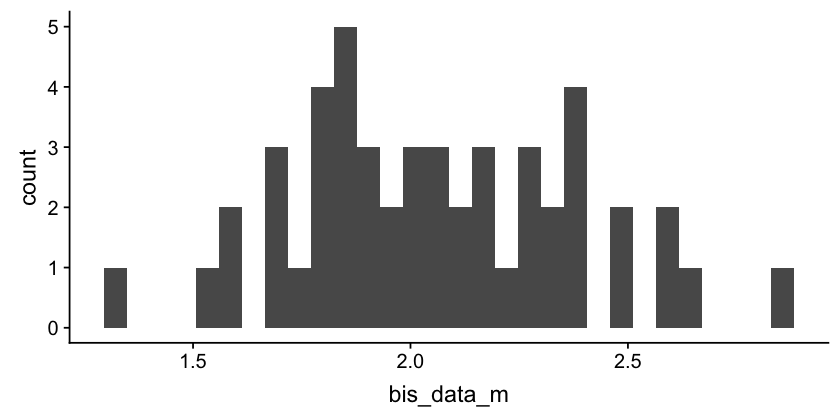

In [84]:
# Call cleanQuestionnaire to clean and reverse-score bis_data
summary(bis_data)
scalesWideRaw$bis_data <- bis_data

# function already accounts for subject column when passing indices for subscales & items to reverse
bis_data_clean <- cleanQuestionnaire(data = bis_data, scaleName = 'bis_data',
                                     scaleMin = 1, scaleMax = 4,
                                     subscales = list(NonPlanning_SelfControl =
                                                      c(1,4,5,6,28,29), # bis_1,7,8,12,13,14
                                                      Motor_Motor = 
                                                      c(9,11,12,15,18,23,25), # bis_2,3,4,17,19,22,25
                                                      Attentional_Attention =
                                                      c(3,13,21,26,30), # bis_5,9,11,20,28
                                                      Attentional_CognitiveInstability =
                                                      c(17,19,27), # bis_6,24,26
                                                      NonPlanning_CognitiveComplexity =
                                                      c(2,7,10,20,22), # bis_10,15,18,27,29
                                                      Motor_Perseverance =
                                                      c(8,14,16,24)), # bis_16,21,23,30
                                     itemsToReverse =
                                     c(1,2,4,5,7,13,22,24,28,29,30)) # bis_1,7,8,9,10,12,13,15,20,29,30

ggplot(bis_data_clean$long[bis_data_subscale == "overall"], aes(bis_data_m)) + geom_histogram()

scales$bis_data_clean <- bis_data_clean

# Reliability (raw_alpha or std.alpha)
bis_data_clean$reliability$NonPlanning_SelfControl$total$raw_alpha
bis_data_clean$reliability$Motor_Motor$total$raw_alpha
bis_data_clean$reliability$Attentional_Attention$total$raw_alpha
bis_data_clean$reliability$Attentional_CognitiveInstability$total$raw_alpha
bis_data_clean$reliability$NonPlanning_CognitiveComplexity$total$raw_alpha
bis_data_clean$reliability$Motor_Perserverence$total$raw_alpha

    subject          pss_1           pss_10          pss_2      
 Min.   :101.0   Min.   :0.000   Min.   :0.000   Min.   :0.000  
 1st Qu.:116.0   1st Qu.:1.000   1st Qu.:1.000   1st Qu.:2.000  
 Median :133.0   Median :2.000   Median :2.000   Median :2.000  
 Mean   :132.2   Mean   :1.959   Mean   :1.639   Mean   :2.224  
 3rd Qu.:147.0   3rd Qu.:2.000   3rd Qu.:3.000   3rd Qu.:3.000  
 Max.   :164.0   Max.   :4.000   Max.   :4.000   Max.   :4.000  
     pss_3           pss_4           pss_5           pss_6      
 Min.   :0.000   Min.   :0.000   Min.   :1.000   Min.   :0.000  
 1st Qu.:2.000   1st Qu.:2.000   1st Qu.:2.000   1st Qu.:1.000  
 Median :3.000   Median :3.000   Median :2.000   Median :2.000  
 Mean   :2.553   Mean   :2.653   Mean   :2.469   Mean   :1.878  
 3rd Qu.:3.000   3rd Qu.:3.000   3rd Qu.:3.000   3rd Qu.:3.000  
 Max.   :4.000   Max.   :4.000   Max.   :4.000   Max.   :4.000  
     pss_7           pss_8           pss_9      
 Min.   :1.000   Min.   :1.000   Min.   :

Expecting wide data with columns in this order:
1. participant number
2, 3, 4... questions


Press 1 to proceed or 0 to stop:  1


Source: local data table [10 x 5]

# A tibble: 10 x 5
   scale    itemName  item toReverse subscale
   <chr>    <chr>    <dbl> <chr>     <chr>   
 1 pss_data pss_1        1 no        pss_data
 2 pss_data pss_10       2 no        pss_data
 3 pss_data pss_2        3 no        pss_data
 4 pss_data pss_3        4 no        pss_data
 5 pss_data pss_4        5 yes       pss_data
 6 pss_data pss_5        6 yes       pss_data
 7 pss_data pss_6        7 no        pss_data
 8 pss_data pss_7        8 yes       pss_data
 9 pss_data pss_8        9 yes       pss_data
10 pss_data pss_9       10 no        pss_data


Computing scale mean...
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


[1] 0.8193564

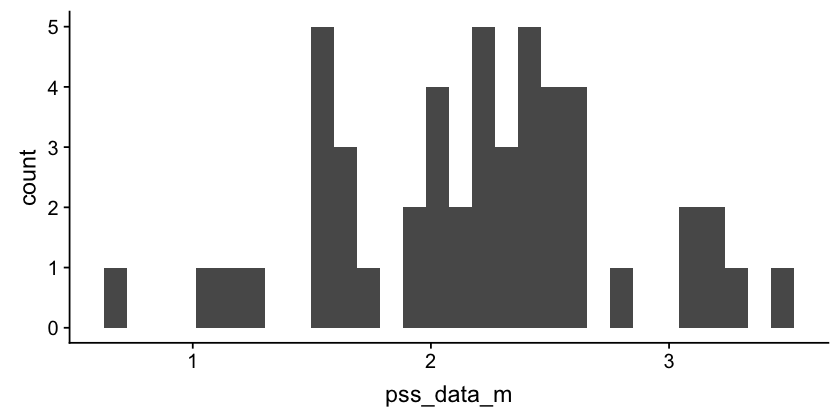

In [85]:
# Call cleanQuestionnaire to clean and reverse-score pss_data
summary(pss_data)
scalesWideRaw$pss_data <- pss_data

# function already accounts for subject column when passing indices for items to reverse
pss_data_clean <- cleanQuestionnaire(data = pss_data, scaleName = 'pss_data',
                                     scaleMin = 0, scaleMax = 4,
                                     itemsToReverse = c(5,6,8,9)) # pss_4,5,7,8

ggplot(pss_data_clean$long, aes(pss_data_m)) + geom_histogram()

scales$pss_data_clean <- pss_data_clean

# Reliability (raw_alpha or std.alpha)
pss_data_clean$reliability$pss_data$total$raw_alpha

    subject         rfs_f_1        rfs_f_10        rfs_f_11        rfs_f_12    
 Min.   :101.0   Min.   :0.00   Min.   :0.000   Min.   :0.000   Min.   :0.000  
 1st Qu.:116.8   1st Qu.:0.00   1st Qu.:2.000   1st Qu.:0.000   1st Qu.:0.000  
 Median :132.5   Median :1.00   Median :2.000   Median :0.000   Median :1.000  
 Mean   :132.3   Mean   :1.13   Mean   :2.304   Mean   :0.587   Mean   :1.325  
 3rd Qu.:147.8   3rd Qu.:2.00   3rd Qu.:3.000   3rd Qu.:1.000   3rd Qu.:2.000  
 Max.   :164.0   Max.   :4.00   Max.   :4.000   Max.   :4.000   Max.   :5.000  
    rfs_f_13        rfs_f_14         rfs_f_15        rfs_f_16    
 Min.   :0.000   Min.   :0.0000   Min.   :0.000   Min.   :0.000  
 1st Qu.:0.000   1st Qu.:0.0000   1st Qu.:0.000   1st Qu.:0.000  
 Median :1.000   Median :0.0000   Median :1.000   Median :1.000  
 Mean   :1.261   Mean   :0.8043   Mean   :1.109   Mean   :1.304  
 3rd Qu.:2.000   3rd Qu.:1.0000   3rd Qu.:2.000   3rd Qu.:2.000  
 Max.   :4.000   Max.   :5.0000   Max.   :5.

Expecting wide data with columns in this order:
1. participant number
2, 3, 4... questions


Press 1 to proceed or 0 to stop:  1


Source: local data table [27 x 5]

# A tibble: 27 x 5
   scale    itemName   item toReverse subscale             
   <chr>    <chr>     <dbl> <chr>     <chr>                
 1 rfs_data rfs_f_1       1 no        Fat                  
 2 rfs_data rfs_f_10      2 no        Fat                  
 3 rfs_data rfs_f_11      3 no        Fat                  
 4 rfs_data rfs_f_12      4 no        Fat                  
 5 rfs_data rfs_f_13      5 no        Fat                  
 6 rfs_data rfs_f_14      6 no        Fat                  
 7 rfs_data rfs_f_15      7 no        Fat                  
 8 rfs_data rfs_f_16      8 no        Fat                  
 9 rfs_data rfs_f_17      9 no        Fat                  
10 rfs_data rfs_f_2      10 no        Fat                  
11 rfs_data rfs_f_3      11 no        Fat                  
12 rfs_data rfs_f_4      12 no        Fat                  
13 rfs_data rfs_f_5      13 no        Fat                  
14 rfs_data rfs_f_6      14 no        Fat     

Computing scale mean...
Warning message in psych::alpha(tempData, check.keys = TRUE):
“Some items were negatively correlated with total scale and were automatically reversed.
 This is indicated by a negative sign for the variable name.”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


[1] 0.5733772

[1] 0.8073628

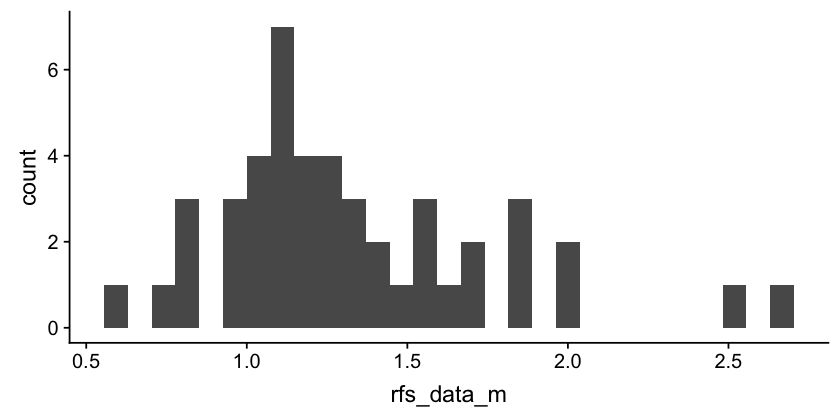

In [86]:
# Call cleanQuestionnaire to clean and reverse-score rfs_data
summary(rfs_data)
scalesWideRaw$rfs_data <- rfs_data

# function already accounts for subject column when passing indices for subscales
rfs_data_clean <- cleanQuestionnaire(data = rfs_data, scaleName = 'rfs_data',
                                     scaleMin = 0, scaleMax = 5,
                                     subscales = list(Fruits_and_Vegetables = 18:27, # rfs_fv_
                                                      Fat = 1:17)) # rfs_f_

ggplot(rfs_data_clean$long[rfs_data_subscale == "overall"], aes(rfs_data_m)) + geom_histogram()

scales$rfs_data_clean <- rfs_data_clean

# Reliability (raw_alpha or std.alpha)
rfs_data_clean$reliability$Fruits_and_Vegetables$total$raw_alpha
rfs_data_clean$reliability$Fat$total$raw_alpha

    subject          tfeq_1        tfeq_10        tfeq_11        tfeq_12    
 Min.   :101.0   Min.   :1.00   Min.   :1.00   Min.   :1.00   Min.   :1.00  
 1st Qu.:116.5   1st Qu.:2.00   1st Qu.:1.00   1st Qu.:1.00   1st Qu.:1.00  
 Median :132.5   Median :2.00   Median :2.00   Median :2.00   Median :2.00  
 Mean   :131.9   Mean   :2.48   Mean   :1.98   Mean   :1.98   Mean   :2.26  
 3rd Qu.:146.8   3rd Qu.:3.00   3rd Qu.:3.00   3rd Qu.:2.00   3rd Qu.:3.00  
 Max.   :164.0   Max.   :4.00   Max.   :4.00   Max.   :4.00   Max.   :4.00  
    tfeq_13        tfeq_14        tfeq_15        tfeq_16        tfeq_17    
 Min.   :1.00   Min.   :1.00   Min.   :1.00   Min.   :1.00   Min.   :1.00  
 1st Qu.:2.00   1st Qu.:2.00   1st Qu.:2.00   1st Qu.:1.00   1st Qu.:1.00  
 Median :2.00   Median :2.00   Median :3.00   Median :2.00   Median :2.00  
 Mean   :2.24   Mean   :2.34   Mean   :2.62   Mean   :2.16   Mean   :2.08  
 3rd Qu.:3.00   3rd Qu.:3.00   3rd Qu.:3.00   3rd Qu.:3.00   3rd Qu.:3.00  
 Max.

Expecting wide data with columns in this order:
1. participant number
2, 3, 4... questions


Press 1 to proceed or 0 to stop:  1


Source: local data table [18 x 5]

# A tibble: 18 x 5
   scale     itemName  item toReverse subscale                 
   <chr>     <chr>    <dbl> <chr>     <chr>                    
 1 tfeq_data tfeq_11      3 no        Cognitive_Restraint_Scale
 2 tfeq_data tfeq_12      4 no        Cognitive_Restraint_Scale
 3 tfeq_data tfeq_15      7 no        Cognitive_Restraint_Scale
 4 tfeq_data tfeq_16      8 no        Cognitive_Restraint_Scale
 5 tfeq_data tfeq_18     10 no        Cognitive_Restraint_Scale
 6 tfeq_data tfeq_2      11 no        Cognitive_Restraint_Scale
 7 tfeq_data tfeq_10      2 no        Emotional_Eating_Scale   
 8 tfeq_data tfeq_3      12 no        Emotional_Eating_Scale   
 9 tfeq_data tfeq_6      15 no        Emotional_Eating_Scale   
10 tfeq_data tfeq_1       1 no        Uncontrolled_Eating_Scale
11 tfeq_data tfeq_13      5 no        Uncontrolled_Eating_Scale
12 tfeq_data tfeq_14      6 no        Uncontrolled_Eating_Scale
13 tfeq_data tfeq_17      9 no        Uncontrolled

Computing scale mean...
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


[1] 0.7447508

[1] 0.7435057

[1] 0.7711006

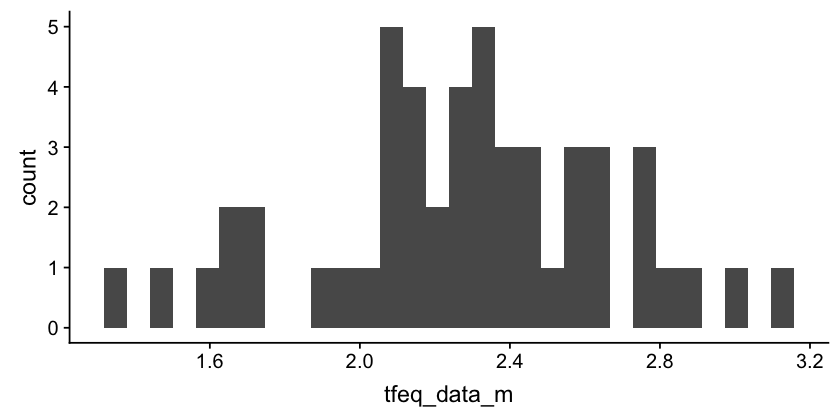

In [87]:
# Call cleanQuestionnaire to clean and reverse-score tfeq_data
summary(tfeq_data)
scalesWideRaw$tfeq_data <- tfeq_data

# function already accounts for subject column when passing indices for subscales
tfeq_data_clean <- cleanQuestionnaire(data = tfeq_data, scaleName = 'tfeq_data',
                                     scaleMin = 1, scaleMax = 4,
                                     subscales = list(Uncontrolled_Eating_Scale =
                                                      c(1,5,6,9,13,14,16,17,18), # tfeq_1,4,5,7,8,9,13,14,17
                                                      Cognitive_Restraint_Scale =
                                                      c(3,4,7,8,10,11), # tfeq_2,11,12,15,16,18
                                                      Emotional_Eating_Scale =
                                                      c(2,12,15))) # tfeq_3,6,10

ggplot(tfeq_data_clean$long[tfeq_data_subscale == "overall"], aes(tfeq_data_m)) + geom_histogram()

scales$tfeq_data_clean <- tfeq_data_clean

# Reliability (raw_alpha or std.alpha)
tfeq_data_clean$reliability$Uncontrolled_Eating_Scale$total$raw_alpha
tfeq_data_clean$reliability$Cognitive_Restraint_Scale$total$raw_alpha
tfeq_data_clean$reliability$Emotional_Eating_Scale$total$raw_alpha

In [88]:
# Combine all subject scores for each scale in one data frame
df1 <- left_join(scales$bis_data_clean$wide, scales$pss_data_clean$wide) %>% 
    left_join(scales$rfs_data_clean$wide) %>% 
    left_join(scales$tfeq_data_clean$wide)

write.csv(df1, "data/questionnaires_clean.csv", row.names = F)

Joining, by = "subject"
Joining, by = "subject"
Joining, by = "subject"


## Questionnaire Key

---
[Coding Google Sheet](https://docs.google.com/spreadsheets/d/1M_YAg-ALHN3SOx1DGVZ9EWd8rX8-QJuatQehSt9CCms/edit?usp=sharing)

---

# Demographics

In [7]:
table(df_good$demo_gender)
tibble(age = mean(as.numeric(df_good$demo_age), na.rm = T), 
       ageSD = sd(as.numeric(df_good$demo_age), na.rm = T),
       ageMin = min(as.numeric(df_good$demo_age), na.rm = T),
       ageMax = max(as.numeric(df_good$demo_age), na.rm = T))


Female   Male 
    34     16 

age,ageSD,ageMin,ageMax
<dbl>,<dbl>,<dbl>,<dbl>
23.1,4.258245,18,38
